# Exploratory Data Analysis (EDA)

In-depth exploration of the credit card transactions dataset, focusing on data quality, class imbalance, temporal patterns, user demographics, merchant/category behavior, and distance-based signals.


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", None)
plt.style.use("seaborn-v0_8")


In [21]:
# Load raw data
from pathlib import Path

project_root = Path.cwd()
if project_root.name == "notebook":
    project_root = project_root.parent

data_path = project_root / "data" / "fraudTest.csv"
raw = pd.read_csv(data_path)

# Remove index-like column if present
if "Unnamed: 0" in raw.columns:
    raw = raw.drop(columns=["Unnamed: 0"])

raw.head()


,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,SC,29209,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,Altonah,UT,84002,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,Bellmore,NY,11710,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,Titusville,FL,32780,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,Falmouth,MI,49632,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


In [22]:
# Basic overview
print("Rows:", raw.shape[0])
print("Columns:", raw.shape[1])

raw.info()


Rows: 555719
Columns: 22
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   trans_date_trans_time  555719 non-null  object 
 1   cc_num                 555719 non-null  int64  
 2   merchant               555719 non-null  object 
 3   category               555719 non-null  object 
 4   amt                    555719 non-null  float64
 5   first                  555719 non-null  object 
 6   last                   555719 non-null  object 
 7   gender                 555719 non-null  object 
 8   street                 555719 non-null  object 
 9   city                   555719 non-null  object 
 10  state                  555719 non-null  object 
 11  zip                    555719 non-null  int64  
 12  lat                    555719 non-null  float64
 13  long                   555719 non-null  float64
 14  city_pop   

In [23]:
# Missing values and duplicates
missing = raw.isna().sum().sort_values(ascending=False)
missing[missing > 0]


Series([], dtype: int64)

In [24]:
dup_count = raw.duplicated().sum()
print("Duplicate rows:", dup_count)


Duplicate rows: 0


is_fraud
0    553574
1      2145
Name: count, dtype: int64
Fraud rate: 0.00386


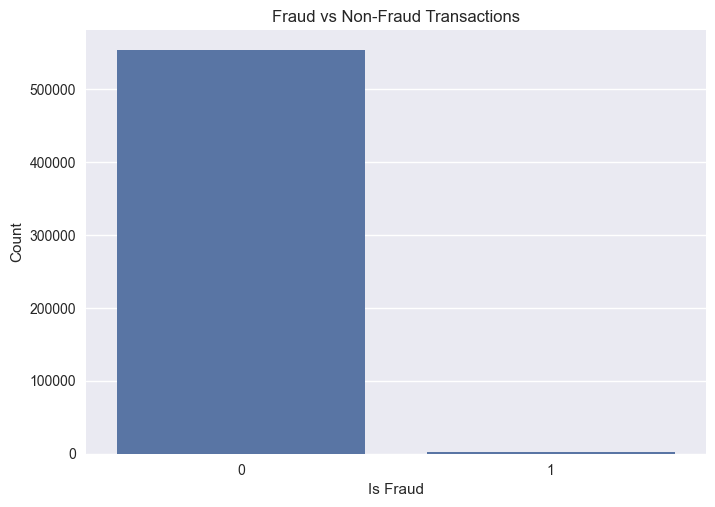

In [25]:
# Class balance
fraud_counts = raw["is_fraud"].value_counts()
fraud_rate = raw["is_fraud"].mean()
print(fraud_counts)
print("Fraud rate:", round(float(fraud_rate), 6))

sns.countplot(x="is_fraud", data=raw)
plt.title("Fraud vs Non-Fraud Transactions")
plt.xlabel("Is Fraud")
plt.ylabel("Count")
plt.show()


In [26]:
# Convert time columns
raw["trans_date_trans_time"] = pd.to_datetime(raw["trans_date_trans_time"])
raw["dob"] = pd.to_datetime(raw["dob"])

raw["trans_hour"] = raw["trans_date_trans_time"].dt.hour
raw["trans_dayofweek"] = raw["trans_date_trans_time"].dt.dayofweek
raw["trans_month"] = raw["trans_date_trans_time"].dt.month

raw[["trans_date_trans_time", "trans_hour", "trans_dayofweek", "trans_month"]].head()


,trans_date_trans_time,trans_hour,trans_dayofweek,trans_month
0,2020-06-21 12:14:25,12,6,6
1,2020-06-21 12:14:33,12,6,6
2,2020-06-21 12:14:53,12,6,6
3,2020-06-21 12:15:15,12,6,6
4,2020-06-21 12:15:17,12,6,6


In [27]:
# Age feature
raw["age"] = ((raw["trans_date_trans_time"] - raw["dob"]).dt.days / 365.25).astype("float")
raw["age"].describe()


count    555719.000000
mean         46.887987
std          17.431204
min          15.392197
25%          33.448323
50%          44.908966
75%          58.056126
max          96.169747
Name: age, dtype: float64

In [28]:
# Sampling for heavy plots
sample_size = min(200000, len(raw))
raw_sample = raw.sample(sample_size, random_state=42)
raw_sample.shape


(200000, 26)

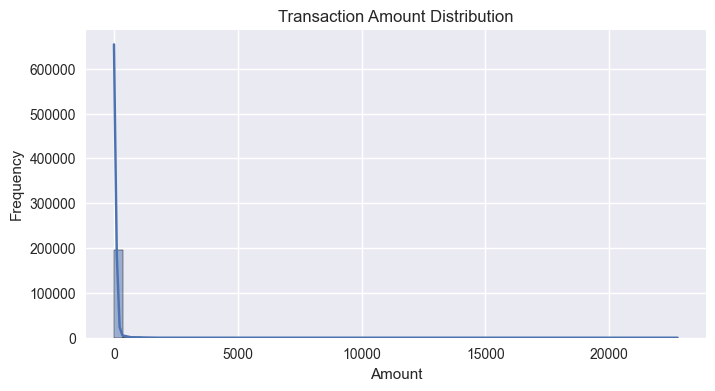

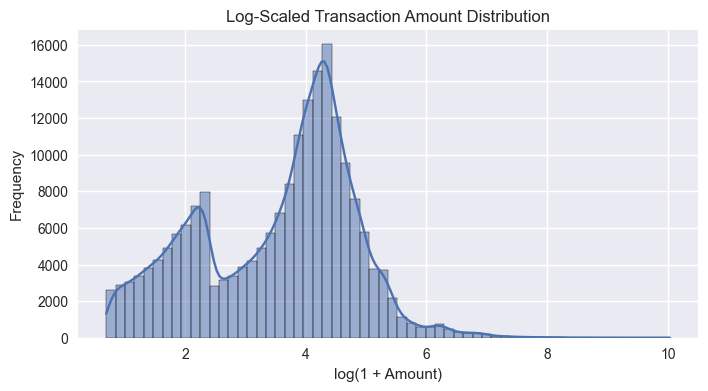

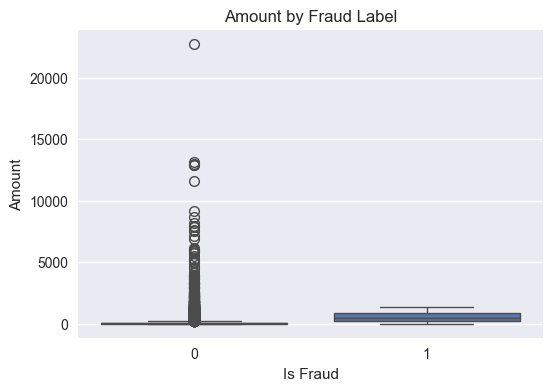

In [29]:
# Transaction amount distribution
plt.figure(figsize=(8, 4))
sns.histplot(raw_sample["amt"], bins=60, kde=True)
plt.title("Transaction Amount Distribution")
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(8, 4))
sns.histplot(np.log1p(raw_sample["amt"]), bins=60, kde=True)
plt.title("Log-Scaled Transaction Amount Distribution")
plt.xlabel("log(1 + Amount)")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(6, 4))
sns.boxplot(x="is_fraud", y="amt", data=raw_sample)
plt.title("Amount by Fraud Label")
plt.xlabel("Is Fraud")
plt.ylabel("Amount")
plt.show()


/var/folders/fq/kr6gv5l17pd4j572n0_n3f2c0000gn/T/ipykernel_44784/3292792567.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_by_amt = raw.groupby(amt_bins)["is_fraud"].mean()


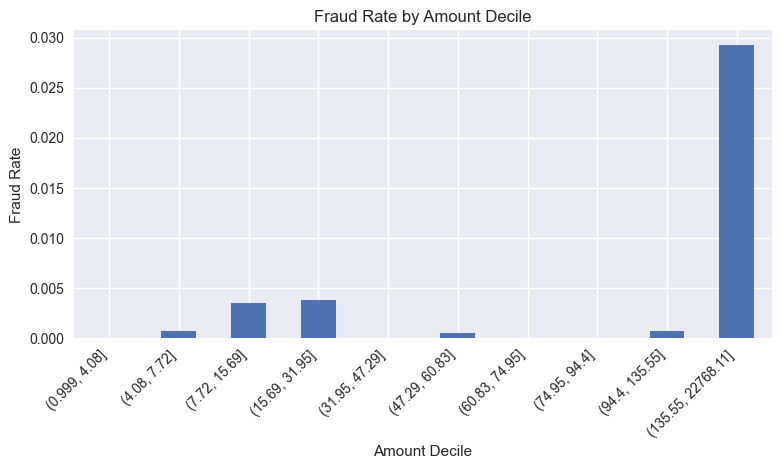

In [30]:
# Fraud rate by amount bins
amt_bins = pd.qcut(raw["amt"], q=10, duplicates="drop")
fraud_by_amt = raw.groupby(amt_bins)["is_fraud"].mean()

plt.figure(figsize=(9, 4))
fraud_by_amt.plot(kind="bar")
plt.title("Fraud Rate by Amount Decile")
plt.xlabel("Amount Decile")
plt.ylabel("Fraud Rate")
plt.xticks(rotation=45, ha="right")
plt.show()


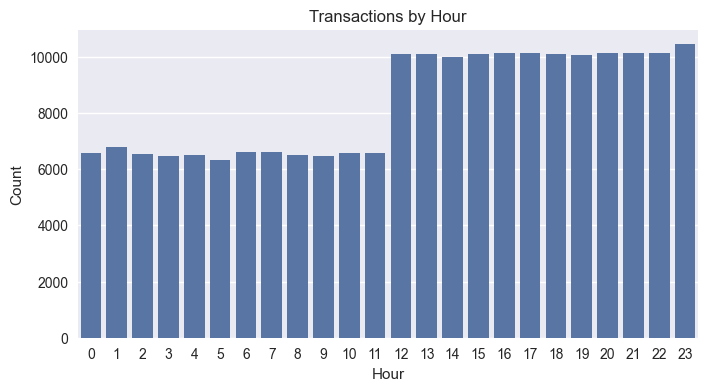

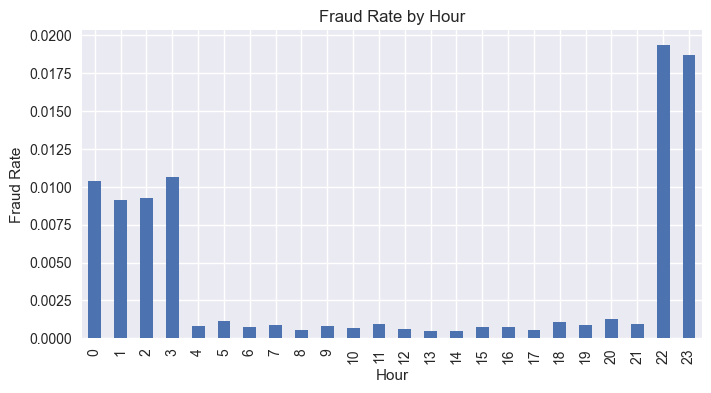

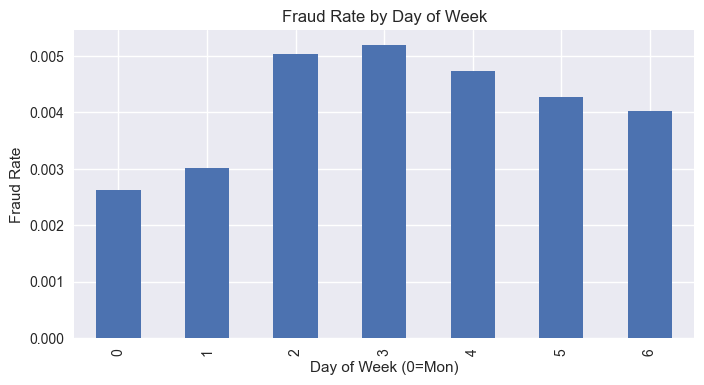

In [31]:
# Time-based patterns
plt.figure(figsize=(8, 4))
sns.countplot(x="trans_hour", data=raw_sample)
plt.title("Transactions by Hour")
plt.xlabel("Hour")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(8, 4))
raw.groupby("trans_hour")["is_fraud"].mean().plot(kind="bar")
plt.title("Fraud Rate by Hour")
plt.xlabel("Hour")
plt.ylabel("Fraud Rate")
plt.show()

plt.figure(figsize=(8, 4))
raw.groupby("trans_dayofweek")["is_fraud"].mean().plot(kind="bar")
plt.title("Fraud Rate by Day of Week")
plt.xlabel("Day of Week (0=Mon)")
plt.ylabel("Fraud Rate")
plt.show()


In [32]:
# Distance feature (Haversine) between customer and merchant

def haversine(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    return 6371 * c

raw["distance_km"] = haversine(raw["lat"], raw["long"], raw["merch_lat"], raw["merch_long"])
raw["distance_km"].describe()


count    555719.000000
mean         76.104902
std          29.117079
min           0.123883
25%          55.286255
50%          78.179517
75%          98.520760
max         150.922504
Name: distance_km, dtype: float64

/var/folders/fq/kr6gv5l17pd4j572n0_n3f2c0000gn/T/ipykernel_44784/290453728.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_by_dist = raw.loc[valid_dist.index].groupby(dist_bins)["is_fraud"].mean()


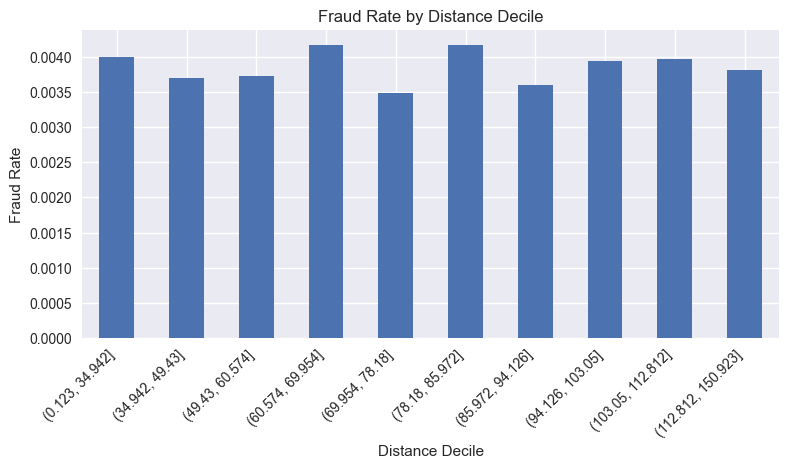

In [33]:
# Fraud rate by distance bins
valid_dist = raw["distance_km"].replace([np.inf, -np.inf], np.nan).dropna()
dist_bins = pd.qcut(valid_dist, q=10, duplicates="drop")
fraud_by_dist = raw.loc[valid_dist.index].groupby(dist_bins)["is_fraud"].mean()

plt.figure(figsize=(9, 4))
fraud_by_dist.plot(kind="bar")
plt.title("Fraud Rate by Distance Decile")
plt.xlabel("Distance Decile")
plt.ylabel("Fraud Rate")
plt.xticks(rotation=45, ha="right")
plt.show()


/var/folders/fq/kr6gv5l17pd4j572n0_n3f2c0000gn/T/ipykernel_44784/2446473834.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_by_age = raw.groupby(age_bins)["is_fraud"].mean()


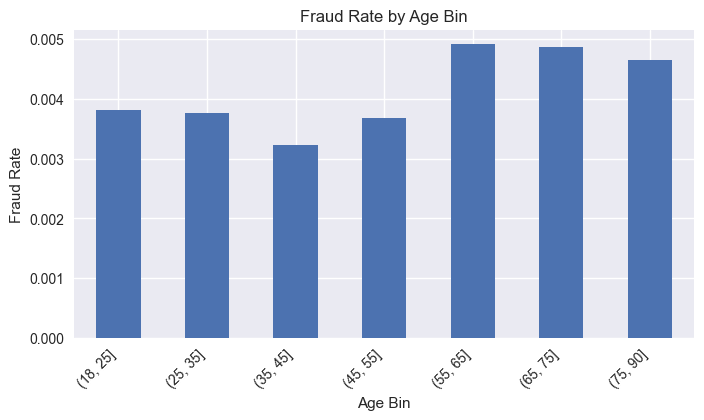

In [34]:
# Age-based analysis
age_bins = pd.cut(raw["age"], bins=[18, 25, 35, 45, 55, 65, 75, 90])
fraud_by_age = raw.groupby(age_bins)["is_fraud"].mean()

plt.figure(figsize=(8, 4))
fraud_by_age.plot(kind="bar")
plt.title("Fraud Rate by Age Bin")
plt.xlabel("Age Bin")
plt.ylabel("Fraud Rate")
plt.xticks(rotation=45, ha="right")
plt.show()


In [35]:
# Categorical feature cardinality
categorical_cols = raw.select_dtypes(include=["object"]).columns
pd.DataFrame({
    "feature": categorical_cols,
    "unique_values": [raw[col].nunique() for col in categorical_cols],
}).sort_values(by="unique_values", ascending=False)


,feature,unique_values
9,trans_num,555719
5,street,924
6,city,849
0,merchant,693
8,job,478
3,last,471
2,first,341
7,state,50
1,category,14
4,gender,2


In [37]:
# Fraud rate for categories with enough volume

def fraud_rate_by_category(df, col, min_count=1000):
    counts = df[col].value_counts()
    keep = counts[counts >= min_count].index
    rates = df[df[col].isin(keep)].groupby(col)["is_fraud"].mean().sort_values(ascending=False)
    return rates

for col in ["category", "merchant", "job", "state", "city"]:
    rates = fraud_rate_by_category(raw, col, min_count=500)
    print(f"Top fraud rates for {col} (min 500 rows):")
    print(rates.head(10))


Top fraud rates for category (min 500 rows):
category
shopping_net     0.012111
misc_net         0.009756
grocery_pos      0.009229
shopping_pos     0.004278
gas_transport    0.002732
travel           0.002292
grocery_net      0.002111
misc_pos         0.002082
personal_care    0.001780
entertainment    0.001471
Name: is_fraud, dtype: float64
Top fraud rates for merchant (min 500 rows):
merchant
fraud_Romaguera, Cruickshank and Greenholt    0.021739
fraud_Lemke-Gutmann                           0.021505
fraud_Mosciski, Ziemann and Farrell           0.020690
fraud_Heathcote, Yost and Kertzmann           0.020482
fraud_Rodriguez, Yost and Jenkins             0.019960
fraud_Medhurst PLC                            0.019430
fraud_Bashirian Group                         0.018987
fraud_Kris-Weimann                            0.018939
fraud_Heathcote LLC                           0.018703
fraud_Bednar Group                            0.018519
Name: is_fraud, dtype: float64
Top fraud rates for 

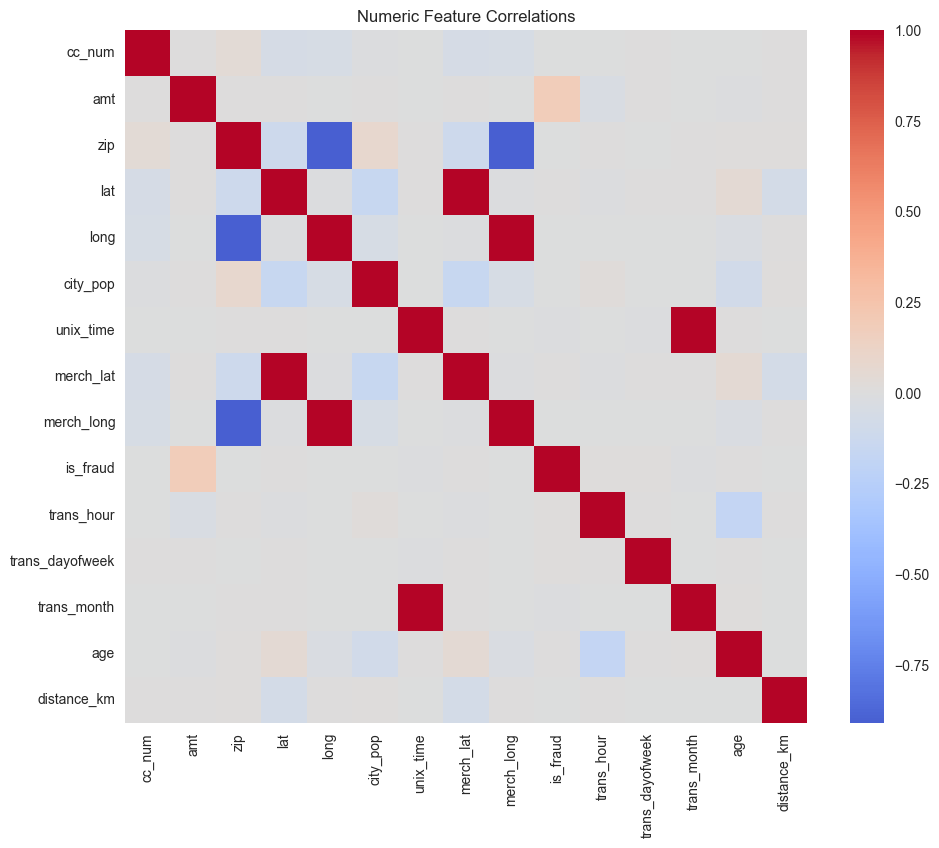

In [38]:
# Numeric correlations
numeric_cols = raw.select_dtypes(include=["number"]).columns
corr = raw[numeric_cols].corr()

plt.figure(figsize=(11, 9))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Numeric Feature Correlations")
plt.show()


In [39]:
# Point-biserial correlation with target
from scipy.stats import pointbiserialr

pb_results = []
for col in numeric_cols:
    if col == "is_fraud":
        continue
    clean = raw[[col, "is_fraud"]].dropna()
    if clean[col].nunique() > 1:
        r, p = pointbiserialr(clean["is_fraud"], clean[col])
        pb_results.append((col, r, p))

pb_df = pd.DataFrame(pb_results, columns=["feature", "r", "p_value"]).sort_values(by="r", ascending=False)
pb_df.head(15)


,feature,r,p_value
1,amt,0.182267,0.000000e+00
9,trans_hour,0.011686,2.999880e-18
10,trans_dayofweek,0.009365,2.925734e-12
12,age,0.007457,2.717840e-08
3,lat,0.005863,1.238354e-05
7,merch_lat,0.005812,1.471158e-05
13,distance_km,0.000233,8.620877e-01
4,long,-0.000972,4.687723e-01
8,merch_long,-0.001060,4.294427e-01
0,cc_num,-0.001540,2.508703e-01


## Summary

- The dataset is highly imbalanced, so precision/recall and PR-AUC will be more informative than accuracy.
- Time-of-day, amount, distance, and category/merchant/job patterns show distinct fraud-rate differences.
- High-cardinality categorical features may need encoding or grouping for modeling.
